In [6]:
import os 
import lightning as L
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt 

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [7]:
class MNISTDataModule(L.LightningDataModule):
    def __init__(self,
                 data_dir = PATH_DATASETS,
                 batch_size = BATCH_SIZE,
                 num_workers = NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        ) 
        
        self.dims = (1, 28, 28)
        self.num_classes = 10
    
    def prepare_data(self) -> None:
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
    
    def train_dataloader(self):
        return DataLoader(
            dataset=self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.mnist_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            dataset=self.mnist_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )


In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [9]:
class GAN(L.LightningModule):
    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 200,
        lr: float = 0.0001,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        # networks
        data_shape = (channels, width, height)
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch):
        imgs, _ = batch

        optimizer_g, optimizer_d = self.optimizers()

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        # train generator
        # generate images
        self.toggle_optimizer(optimizer_g)
        self.generated_imgs = self(z)

        # log sampled images
        sample_imgs = self.generated_imgs[:6]
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, 0)

        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        # adversarial loss is binary cross-entropy
        g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
        print(g_loss)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        # train discriminator
        # Measure discriminator's ability to classify real from generated samples
        self.toggle_optimizer(optimizer_d)

        # how well can it label as real?
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

        # how well can it label as fake?
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

    def plot_generated_images(self):
        n_images = 3
        noise = torch.randn(3, self.hparams.latent_dim)
        noise = noise.type_as(self.generator.lin1.weight)

        generated_images = self.generator(noise)
        generated_images = generated_images.view(-1, 28, 28)
        generated_images = generated_images.detach().cpu()

        for image in generated_images:
            plt.figure()
            plt.imshow(image, cmap="gray")
        
        plt.show()
        
    def on_train_epoch_end(self):
        self.plot_generated_images()
        
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_validation_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tymqsz/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | In sizes | Out sizes     
----------------------------------------------------------------------------
0 | generator     | Generator     | 672 K  | [2, 200] | [2, 1, 28, 28]
1 | discriminator | Discriminator | 21.4 K | ?        | ?             
----------------------------------------------------------------------------
693 K     Trainable params
0         Non-trainable params
693 K     Total params
2.774     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 215/215 [00:07<00:00, 27.15it/s, v_num=50, g_loss=0.947, d_loss=0.265]

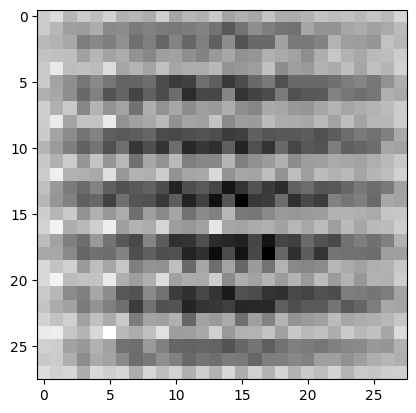

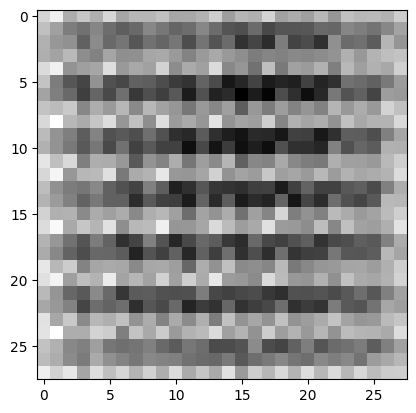

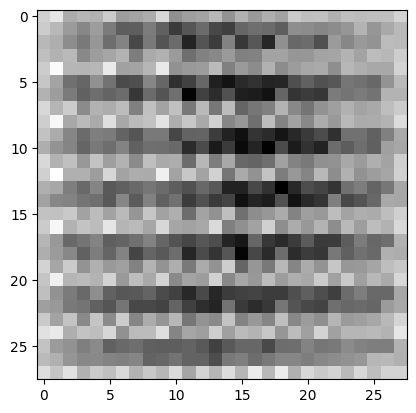

Epoch 1: 100%|██████████| 215/215 [00:07<00:00, 27.57it/s, v_num=50, g_loss=1.490, d_loss=0.332]

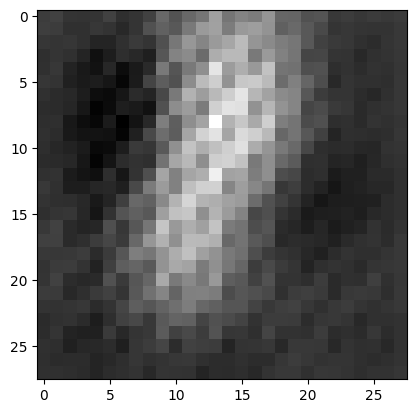

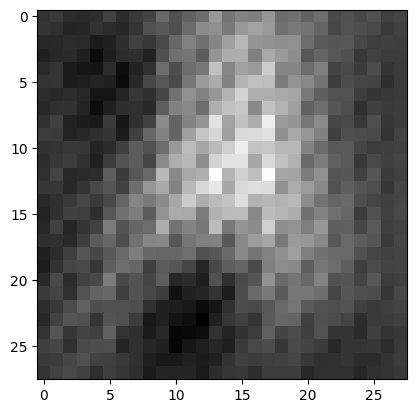

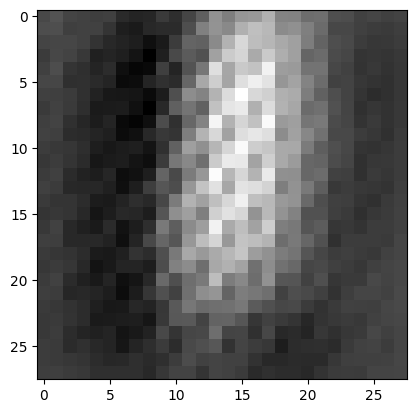

Epoch 2: 100%|██████████| 215/215 [00:08<00:00, 26.67it/s, v_num=50, g_loss=1.660, d_loss=0.346]

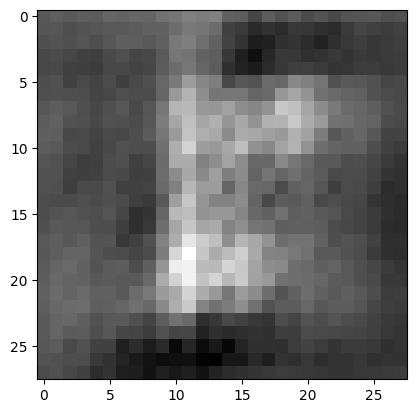

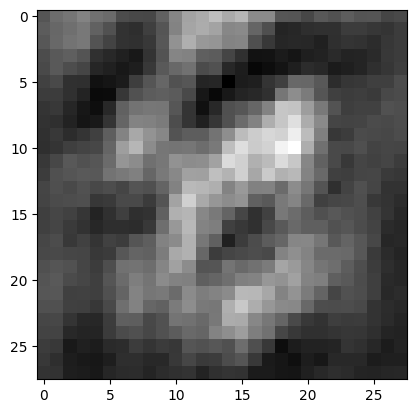

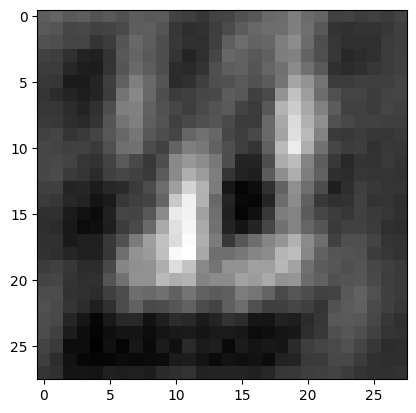

Epoch 3: 100%|██████████| 215/215 [00:07<00:00, 26.99it/s, v_num=50, g_loss=1.460, d_loss=0.412]

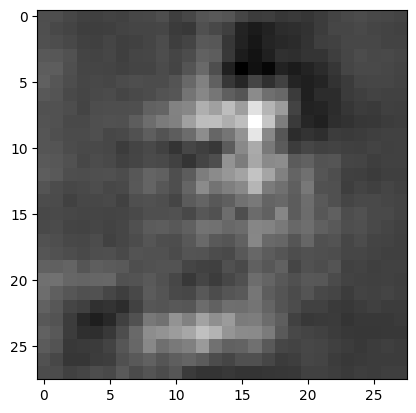

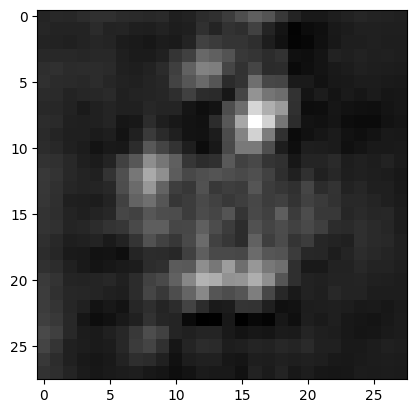

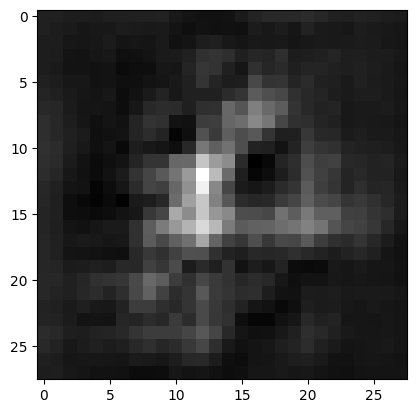

Epoch 4:  79%|███████▊  | 169/215 [00:06<00:01, 26.75it/s, v_num=50, g_loss=1.620, d_loss=0.349]tensor(1.6971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [10]:
dm = MNISTDataModule()
model = GAN(*dm.dims)
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=100,
)
trainer.fit(model, dm)